In [1]:
from self_supervised.pipelines.representation_model import RepresentationModel, YoloEncoder
from ultralytics.models.yolo.detect.train import DetectionModel
import torch
from segment_anything import SamPredictor, sam_model_registry

%reload_kedro
model_description = catalog.load("yolov8_l_description")
# trained_model = catalog.load("trained_model", version="2023-03-23T12.37.00.000Z")
trained_model = torch.load("../checkpoints/checkpoint_52360.pt", map_location="cpu")

# Random model
# encoder = YoloEncoder(model_description=model_description)
# trained_model = RepresentationModel(encoder=encoder)

# CoCO model
# model_description["head"] = model_description["head"][:-1]
# trained_model = DetectionModel(model_description)
# weights_model = torch.load("../yolov8l.pt", map_location="cpu")
# state_dict = weights_model["model"].float().state_dict()
# trained_model.load_state_dict(state_dict, strict=False)

# SAM model
#sam = sam_model_registry["vit_b"](checkpoint="../sam_vit_b_01ec64.pth")
#predictor = SamPredictor(sam)

# def trained_model(image):
#     predictor.set_image(image[0])
#     rep = predictor.get_image_embedding()
#     return torch.mean(rep, dim=(2, 3))

projection = trained_model.projection
trained_model = trained_model.encoder
trained_model = trained_model.eval()
projection = projection.eval()

2024-04-18 16:06:34,238 - kedro.ipython - INFO - Resolved project path as: /home/daniel/git/self-supervised-learning.
To set a different path, run '%reload_kedro <project_root>'
2024-04-18 16:06:34,246 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/startup.py:99: KedroDeprecationWarning: project_version in pyproject.toml is deprecated, use kedro_init_version instead
  warnings.warn(

2024-04-18 16:06:34,378 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/kedro/framework/session/session.py:267: KedroDeprecationWarning: TemplatedConfigLoader will be deprecated in Kedro 0.19. Please use the OmegaConfigLoader instead. To consult the documentation for OmegaConfigLoader, see here: https://docs.kedro.org/en/stable/configuration/advanced_configuration.html#omegaconfigloader
  warnings.warn(

2024-04-18 16:06:34,400 - py.warnings - WARNING - /home/daniel/git/self-superv

In [5]:
# Aerial
# TRAIN_SPLIT = "active_1"
# TEST_SPLIT = "2018-08-22"

# Ground
TRAIN_SPLIT = "ssl_active_3"
TEST_SPLIT = "ssl_active_2"

In [6]:
from pathlib import Path

dataset_path = Path("/home/daniel/lab_share/projects/CottonFlower2021/flower_dataset")
image_dir = dataset_path / TRAIN_SPLIT / "images"

In [7]:
# import random
# random.sample(range(160), 10)

# indices = [143, 159, 78, 12, 34, 116, 118, 0, 44, 124]

In [8]:
from torchvision.io import read_image
from torchvision.transforms.functional import resize
from tqdm import tqdm
import torch
from typing import Tuple, List
import numpy as np

def extract_image_reps(image_list: List[Path]) -> Tuple[List[np.array], List[np.array]]:
    image_reps = []
    image_reps_low_dim = []

    for image_path in tqdm(image_list):
        image = read_image(image_path.as_posix())
        image.requires_grad = False
        image = resize(image, (512, 512))
        image = image.to(torch.float) / 255
        image_ex = image[None, :, :, :]

        image_rep = trained_model(image_ex).detach()
        image_reps.append(image_rep[0].reshape((1, -1)).numpy())
                          
    return image_reps, image_reps_low_dim


def extract_image_reps_dir(image_dir_: Path) -> Tuple[List[np.array], List[np.array]]:
    image_list = sorted(list(image_dir_.iterdir()))
    return extract_image_reps(image_list)
                          


In [9]:
image_reps, image_reps_low_dim = extract_image_reps_dir(image_dir)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:06<00:00,  6.06it/s]


In [10]:
# Load flower counts.
import pandas as pd

labels_dir = dataset_path / TRAIN_SPLIT / "labels"
all_labels = []
labels_list = sorted(list(labels_dir.iterdir()))
# labels_list = [labels_list[i] for i in indices]
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels.append(frame_labels)
    
all_labels = pd.concat(all_labels, ignore_index=True)
all_labels

,class,x,y,width,height,frame
0,0,0.486813,0.601333,0.023875,0.044778,clip1022_cam0_frame281.txt
1,0,0.382328,0.692620,0.018302,0.033500,clip1022_cam0_frame281.txt
2,0,0.395656,0.468602,0.026604,0.049463,clip1022_cam0_frame281.txt
3,0,0.126042,0.211667,0.022583,0.053519,clip1066_cam1_frame889.txt
4,0,0.979370,0.137454,0.033531,0.058389,clip1066_cam1_frame889.txt
5,0,0.381969,0.055343,0.021208,0.042574,clip1066_cam1_frame902.txt
6,0,0.803849,0.091833,0.038323,0.088815,clip1066_cam1_frame902.txt
7,0,0.031260,0.313241,0.057479,0.093667,clip1240_cam0_frame626.txt
8,0,0.142120,0.593657,0.046531,0.124093,clip1240_cam0_frame626.txt
9,0,0.017688,0.347917,0.035375,0.072981,clip1240_cam0_frame626.txt


In [11]:
import numpy as np

# Create flower counts labels.
flower_counts = []
for image_path in labels_list:
    flower_counts.append(np.count_nonzero(all_labels["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(flower_counts), len(image_reps)):
    flower_counts.append(0)

In [12]:
test_image_dir = dataset_path / TEST_SPLIT / "images"

test_image_reps, test_image_reps_low_dim = extract_image_reps_dir(test_image_dir)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.89it/s]


In [13]:
test_labels_dir = dataset_path / TEST_SPLIT / "labels"
all_labels_test = []
labels_list = sorted(list(test_labels_dir.iterdir()))
for labels_path in labels_list:
    frame_labels = pd.read_csv(labels_path, sep=" ", names=["class", "x", "y", "width", "height"])
    frame_labels["frame"] = labels_path.name
    all_labels_test.append(frame_labels)
    
all_labels_test = pd.concat(all_labels_test, ignore_index=True)
all_labels_test

,class,x,y,width,height,frame
0,0,0.232073,0.450046,0.051396,0.087981,clip1022_cam2_frame303.txt
1,0,0.031250,0.700046,0.039021,0.068537,clip1022_cam2_frame303.txt
2,0,0.735323,0.259694,0.025229,0.043981,clip1022_cam2_frame303.txt
3,0,0.609214,0.966546,0.033781,0.058389,clip1030_cam2_frame225.txt
4,0,0.810750,0.796917,0.024750,0.050759,clip1030_cam2_frame225.txt
5,0,0.817891,0.397602,0.026656,0.057537,clip1044_cam2_frame119.txt
6,0,0.140938,0.296065,0.038542,0.045685,clip1076_cam1_frame518.txt
7,0,0.175677,0.643370,0.049021,0.095593,clip1356_cam2_frame44.txt
8,0,0.465021,0.310454,0.039500,0.089685,clip1365_cam2_frame3097.txt
9,0,0.847870,0.398861,0.027594,0.029611,clip1367_cam1_frame3117.txt


In [14]:
# Create flower counts.
test_flower_counts = []
for image_path in labels_list:
    test_flower_counts.append(np.count_nonzero(all_labels_test["frame"] == image_path.name))
    
# Any missing counts are zeros.
for _ in range(len(test_flower_counts), len(test_image_reps)):
    test_flower_counts.append(0)

In [15]:
from sklearn.model_selection import PredefinedSplit

# Create combined dataset.
all_image_reps = image_reps + test_image_reps
all_flower_counts = flower_counts + test_flower_counts
train_indices = [-1] * len(image_reps)
test_indices = [0] * len(test_image_reps)
split = PredefinedSplit(train_indices + test_indices)

In [16]:
from sklearn.linear_model import RidgeCV, Ridge

all_flower_counts = np.array(all_flower_counts, dtype=float)
all_image_reps_arr = np.concatenate(all_image_reps, axis=0)

alphas = [1e-6, 1e-4, 0.01, 0.1, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0]
reg_search = RidgeCV(alphas=alphas, cv=split).fit(all_image_reps_arr, all_flower_counts)
# RidgeCV is going to go and refit on the whole dataset once it finds the best alpha, which we don't want.
# Fit manually with the best alpha on just the training data.
reg = Ridge(reg_search.alpha_).fit(np.concatenate(image_reps, axis=0), np.array(flower_counts))

2024-04-18 16:07:02,845 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(

2024-04-18 16:07:03,117 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(

2024-04-18 16:07:03,343 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(

2024-04-18 16:07:03,596 - py.warnings - WARNING - /home/daniel/git/self-supervised-learning/.venv/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:243: UserWarning: Singu

In [17]:
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([     1.9748,      2.1231,      1.8337,      1.9812,     0.71473,      1.8293,     0.61843,       1.297,     0.83767,      1.1994,      1.0726,     0.94229,     0.80765,     0.59542,       1.033,     0.49398,      2.2474,      0.8104,     0.79924,     0.63422], dtype=float32)

In [18]:
errors = test_preds - test_flower_counts
np.mean(np.abs(errors))

0.8768546253442764

In [19]:
# Calculate MAPE.
errors = np.abs(test_preds - test_flower_counts) / ((np.abs(test_preds) + np.abs(test_flower_counts)) / 2) * 100
np.mean(errors)

130.46109137123725

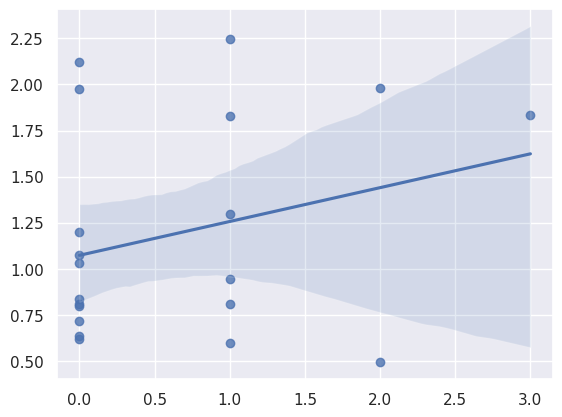

In [20]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

sns.regplot(x=test_flower_counts, y=test_preds)
plt.show()

<Axes: ylabel='Count'>

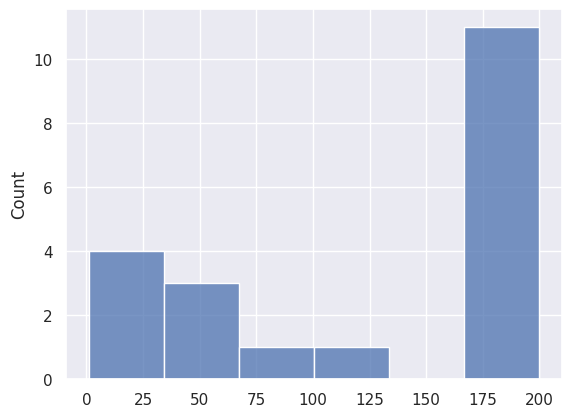

In [21]:
sns.histplot(x=errors)

In [19]:
from pathlib import Path
from typing import Tuple, List
import numpy as np

# Load the plot status data.
PLOT_STATUS_DATA_PATH = Path("/home/daniel/lab_share/projects/SSL/plot_status_dataset")
train_dir = PLOT_STATUS_DATA_PATH / "train"
test_dir = PLOT_STATUS_DATA_PATH / "test"

LABEL_MAP = {"in_plot": 0, "between_plots": 1, "headland": 2}

def collect_images_and_labels(data_dir: Path) -> Tuple[List[Path], np.array]:
    image_paths = []
    labels = []
    
    for category_dir in data_dir.iterdir():
        for image_path in category_dir.iterdir():
            image_paths.append(image_path)
            labels.append(LABEL_MAP[category_dir.name])
            
    return image_paths, np.array(labels)

train_images, train_labels = collect_images_and_labels(train_dir)
test_images, test_labels = collect_images_and_labels(test_dir)

In [20]:
# Compute image representations.
train_image_reps, _ = extract_image_reps(train_images)
test_image_reps, _ = extract_image_reps(test_images)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.74it/s]


In [21]:
from sklearn.model_selection import PredefinedSplit

# Create combined dataset.
all_image_reps = np.concatenate(train_image_reps + test_image_reps, axis=0)
all_plot_status = np.concatenate([train_labels, test_labels], axis=0)
train_indices = [-1] * len(train_image_reps)
test_indices = [0] * len(test_image_reps)
split = PredefinedSplit(train_indices + test_indices)

In [22]:
# Fit the model.
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

alphas = [1e-4, 0.01, 0.1, 1.0, 2.0, 8.0, 32.0, 64.0, 128.0]
reg_search = LogisticRegressionCV(Cs=alphas, cv=split).fit(all_image_reps, all_plot_status)
# LogisticRegressionCV is going to go and refit on the whole dataset once it finds the best alpha, which we don't want.
# Fit manually with the best alpha on just the training data.
reg = LogisticRegression(C=np.mean(reg_search.C_)).fit(np.concatenate(train_image_reps, axis=0), train_labels)

In [23]:
# Compute predictions on test set.
test_image_reps_arr = np.concatenate(test_image_reps, axis=0)
test_preds = reg.predict(test_image_reps_arr)
test_preds

array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
# Calculate accuracy.
test_accuracy = np.sum(test_preds == test_labels) / len(test_labels)
test_accuracy

1.0